In [25]:
import dataset_utils
from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import numpy as np
import time
data_path = "./fvec_datasets/Cancer.fvec"
Index_path = "./data/index_Cancer_R64_L100_A1.2"
adj_dict = dataset_utils.Index_read(Index_path)

print("--")
adj_dict = dataset_utils.Index_read(Index_path)
sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,input_file = data_path, aproximate_almost_zero=False)
MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
l = MST.nonzero()
print(len(l[0]))
print(len(l[1]))
print(MST.getnnz())
print(len(MST.data))

sparse_adj_matrix
print(sparse_adj_matrix.getnnz())







--
459
459
459
459
9782


In [39]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
X = csr_matrix([[0, 3, 0, 2],
                [3, 0, 3, 5],
                [0, 3, 0, 2],
                [2, 5, 2, 0]])
X[0,2] = 0
X[2,0] = 0
Tcsr = minimum_spanning_tree(X)
print(Tcsr)
print(f'non-zero entries: {Tcsr.nnz}')

  (0, 1)	3.0
  (0, 3)	2.0
non-zero entries: 2


In [1]:
def MST_time_compare(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time

    

    print("--")
    start = time.time()
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
    end = time.time()
    sparse_matrix_building_time = end - start
    

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()
    MST_from_sparse_time = end - start


    # MST_from_sparse_weight = MST.data.sum()


    


    start = time.time()
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=True)
    end = time.time()
    
    sparse_matrix_noise_building_time = end - start
    # ngb = adj_dict[32][0]
    # print(f"Distance between 32 and {ngb} from adj_matrix:",sparse_adj_matrix[32,ngb])
    # input = dataset_utils.fvecs_read("fvec_datasets/sift_learn.fvecs")
    # print(f"Distance between 32 and {ngb} from input:",np.linalg.norm(input[32,:] - input[ngb,:]))

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()

    MST_from_sparse_noise_time = end - start


    # MST_from_sparse_noise_weight = MST.data.sum()


    #Dense approach
    try:
        start_block = time.time()
        start = time.time()
        input = dataset_utils.fvecs_read(data_path)
        print( "time to read", time.time() - start)
        dense_adj_matrix =  squareform(pdist(input))
        end = time.time()
        dense_matrix_building_time = end - start
        print(dense_matrix_building_time)
        start = time.time()
        mst = minimum_spanning_tree(dense_adj_matrix)
        end = time.time()
        

        MST_from_dense_time = end - start
        print(MST_from_dense_time)
        # MST_from_dense_weight = mst.data.sum()
                
    except Exception as e:

        print(e)
        end_block = time.time()
        print(end_block - start_block)


        dense_matrix_building_time = np.inf

        MST_from_dense_time = np.inf

        MST_from_dense_weight = np.inf

    return [sparse_matrix_building_time, MST_from_sparse_time, sparse_matrix_noise_building_time, MST_from_sparse_noise_time, dense_matrix_building_time,  MST_from_dense_time]
        











In [2]:
def compare_datasets_mst():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = [] 
    
    for dataset in list_of_files:
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_time_compare(data_path, index_path)
        
        print(name, result)
        results.append(result)

    col_names = ["sparse_matrix_building_time", "MST_from_sparse_time", "sparse_matrix_noise_building_time", "MST_from_sparse_noise_time", "dense_matrix_building_time",  "MST_from_dense_time"]

    df = pd.DataFrame(results, columns = col_names)
    return df
    

    
    

df = compare_datasets_mst()

--
time to read 0.0
0.0
0.0
iris [0.0, 0.0, 0.015805482864379883, 0.0, 0.0, 0.0]
--
time to read 0.0
0.0
0.0
seeds [0.017101764678955078, 0.0, 0.015896081924438477, 0.0, 0.0, 0.0]
--
time to read 0.0
0.015091180801391602
0.05748748779296875
Cancer [0.06663846969604492, 0.0, 0.06781482696533203, 0.0, 0.015091180801391602, 0.05748748779296875]
--
time to read 0.0
0.06289243698120117
0.8172929286956787
mfeat [0.2624680995941162, 0.0, 0.3740873336791992, 0.0, 0.06289243698120117, 0.8172929286956787]
--
time to read 0.06249594688415527
Unable to allocate 74.5 GiB for an array with shape (100000, 100000) and data type float64
711.1883335113525
sift_learn [48.73481059074402, 1.444870948791504, 59.85625648498535, 1.6549639701843262, inf, inf]
--


KeyboardInterrupt: 

In [14]:
df

,sparse_matrix_building_time,MST_from_sparse_time,MST_from_sparse_weight,sparse_matrix_noise_building_time,MST_from_sparse_noise_time,MST_from_sparse_noise_weight,dense_matrix_building_time,MST_from_dense_time,MST_from_dense_weight
0,0.019058,0.000000,4.398371e+01,0.014961,0.000000,4.337274e+01,0.001994,0.010973,4.398371e+01
1,0.016951,0.000998,1.015096e+02,0.020951,0.000000,1.015097e+02,0.000994,0.005984,1.015096e+02
2,0.078349,0.000998,1.653567e+03,0.088286,0.000997,1.399327e+03,0.005993,0.070669,1.648194e+03
3,0.297659,0.004993,2.165715e+04,0.412115,0.005964,2.159259e+04,0.077373,0.845494,2.165625e+04
4,48.952452,1.678169,2.102798e+07,66.747716,1.739800,2.097714e+07,inf,inf,inf
5,32.503515,1.027806,6.492097e+07,37.309481,0.803302,6.492097e+07,inf,inf,inf


In [ ]:
def MST_time_compare2(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time

    adj_dict = dataset_utils.Index_read(Index_path)

    print("--")
    start = time.time()
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
    end = time.time()
    sparse_matrix_building_time = end - start
    

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()
    MST_from_sparse_time = end - start




    #Dense approach
    
    
    try:
        start = time.time()
        input = dataset_utils.fvecs_read(data_path)
        dense_adj_matrix =  squareform(pdist(input))
        end = time.time()
        dense_matrix_building_time = end - start
        start = time.time()
        mst = minimum_spanning_tree(dense_adj_matrix)
        end = time.time()

        MST_from_dense_time = end - start
                
    except:

        dense_matrix_building_time = np.inf

        MST_from_dense_time = np.inf

        # MST_from_dense_weight = np.inf

    return [sparse_matrix_building_time, MST_from_sparse_time,  dense_matrix_building_time,  MST_from_dense_time]
        











In [3]:
def compare_datasets_mst2():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = [] 
    
    for dataset in list_of_files:
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_time_compare2(data_path, index_path)
        
        print(name, result)
        results.append(result)

    col_names = ["sparse_matrix_building_time", "MST_from_sparse_time",  "dense_matrix_building_time",  "MST_from_dense_time"]

    df = pd.DataFrame(results, columns = col_names)
    return df
    

compare_datasets_mst2()

--
iris [0.009673118591308594, 0.0, 0.0009970664978027344, 0.003992319107055664]
--
seeds [0.01744675636291504, 0.0009999275207519531, 0.0, 0.008656501770019531]
--
Cancer [0.05540728569030762, 0.000997781753540039, 0.00299072265625, 0.06244778633117676]
--
mfeat [0.2688286304473877, 0.0, 0.07733011245727539, 0.7709779739379883]
--


In [2]:
def MST_time_compare_mlpack(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time
    import mlpack

    

    print("--")
    start = time.time()
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
    end = time.time()
    sparse_matrix_building_time = end - start
    

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()
    MST_from_sparse_time = end - start


    # MST_from_sparse_weight = MST.data.sum()


    


    start = time.time()
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=True)
    end = time.time()
    
    sparse_matrix_noise_building_time = end - start
    # ngb = adj_dict[32][0]
    # print(f"Distance between 32 and {ngb} from adj_matrix:",sparse_adj_matrix[32,ngb])
    # input = dataset_utils.fvecs_read("fvec_datasets/sift_learn.fvecs")
    # print(f"Distance between 32 and {ngb} from input:",np.linalg.norm(input[32,:] - input[ngb,:]))

    start = time.time()
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    end = time.time()

    MST_from_sparse_noise_time = end - start


    # MST_from_sparse_noise_weight = MST.data.sum()


    #Dense approach
    try:
        start_block = time.time()
        start = time.time()
        input = dataset_utils.fvecs_read(data_path)
        print( "time to read", time.time() - start)
        d = mlpack.emst(input_ = input)
        end = time.time()
        MST_mlpack_time = end - start

        
                
    except Exception as e:

        print(e)
        end_block = time.time()
        print(end_block - start_block)
        MST_mlpack_time = np.inf


    return [sparse_matrix_building_time, MST_from_sparse_time, sparse_matrix_noise_building_time, MST_from_sparse_noise_time, MST_mlpack_time]
        











In [3]:
def compare_datasets_mst_mlpack():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = [] 
    
    for dataset in list_of_files:
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_time_compare_mlpack(data_path, index_path)
        
        print(name, result)
        results.append(result)

    col_names = ["sparse_matrix_building_time", "MST_from_sparse_time", "sparse_matrix_noise_building_time", "MST_from_sparse_noise_time", "MST_mlpack_time"]

    df = pd.DataFrame(results, columns = col_names)
    return df
    

df = compare_datasets_mst_mlpack()

df.to_csv("ml_pack_comparison.csv")

--
time to read 0.0
iris [0.03124403953552246, 0.009010791778564453, 0.024194955825805664, 0.0010039806365966797, 0.0025272369384765625]
--
time to read 0.0
seeds [0.031153202056884766, 0.0, 0.041251182556152344, 0.0, 0.00601959228515625]
--
time to read 0.0
Cancer [0.1687014102935791, 0.001992464065551758, 0.2008817195892334, 0.015621185302734375, 0.019993066787719727]
--
time to read 0.0
mfeat [0.6668143272399902, 0.02113509178161621, 0.7903754711151123, 0.004837751388549805, 0.5595531463623047]
--
time to read 0.06496334075927734
sift_learn [40.981314182281494, 0.8827199935913086, 76.96798610687256, 1.766503095626831, 5163.291917800903]
--


In [1]:
import dataset_utils
from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import numpy as np
import time
import mlpack

data_path = "./fvec_datasets/mnist.fvec"
Index_path = "./data/index_mnist_R64_L100_A1.2"

print("--")
start = time.time()
adj_dict = dataset_utils.Index_read(Index_path)
sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,data_path, aproximate_almost_zero=False)
end = time.time()
sparse_matrix_building_time = end - start


start = time.time()
MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
end = time.time()
MST_from_sparse_time = end - start

print("sparse matrix building time: ",sparse_matrix_building_time)
print("MST building time: ",MST_from_sparse_time)

--
sparse matrix building time:  38.511393547058105
MST building time:  0.9137058258056641


In [16]:
import dataset_utils
from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.sparse import csr_matrix
import numpy as np
import time


data_path = "./fvec_datasets/Cancer.fvec"
start = time.time()
input = dataset_utils.fvecs_read(data_path)
print( "time to read", time.time() - start)
d = mlpack.emst(input_ = input)
end = time.time()
MST_mlpack_time = end - start
print(d)
print(type(d['output']))
output1 = d['output']



time to read 0.002507448196411133
{'output': array([[448.        , 496.        ,   0.        ],
       [496.        , 617.        ,   0.        ],
       [393.        , 496.        ,   0.        ],
       ...,
       [ 85.        ,  98.        ,   7.14142843],
       [ 71.        , 648.        ,   9.05538514],
       [167.        , 506.        ,   9.16515139]])}
<class 'numpy.ndarray'>
(698, 3)


In [14]:
def MST_test_weights(data_path, Index_path):
    import dataset_utils
    from dataset_utils import Index_read, Compute_adj_matrix, Compute_MST_from_adj,fvecs_read
    from scipy.spatial.distance import pdist, squareform
    from scipy.sparse.csgraph import minimum_spanning_tree
    from scipy.sparse import csr_matrix
    import numpy as np
    import time
    import mlpack

    

    print("--")
    
    adj_dict = dataset_utils.Index_read(Index_path)
    sparse_adj_matrix = dataset_utils.Compute_adj_matrix(adj_dict,input_file = data_path, aproximate_almost_zero=False)
    MST = dataset_utils.Compute_MST_from_adj(sparse_adj_matrix)
    ANN_weight = MST.data.sum()
    

    try:

        input = dataset_utils.fvecs_read(data_path)
        d = mlpack.emst(input_ = input)
        d = d['output']
        mlpack_weight = d[:,2].sum()
        
                
    except Exception as e:
        print(e)
        mlpack_weight = np.inf


    return [ANN_weight, mlpack_weight]
        




In [15]:
def run_all_ANN_tests():
    import os 
    import pandas as pd
    import time
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                       (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                       (os.path.join(name_of_dir, x)).st_size)

    results = []
    datasets =[]

    for dataset in list_of_files:
        if(dataset in ["mnist.fvec"]):
            continue
        datasets.append(dataset)
        
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        
        result = MST_test_weights(data_path, index_path)
        
        
        results.append(result)

        col_names = ["Approximate MST weight","mlpack MST weight"]

    df = pd.DataFrame(results, columns = col_names)
    
    
    df.index = datasets
    return df
    

df =run_all_ANN_tests()


--
--
--
--
--


In [29]:
df["percentual error"] = abs((df["Approximate MST weight"] - df["mlpack MST weight"])/df["mlpack MST weight"])

In [30]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(df)
    

                  Approximate MST weight  mlpack MST weight  percentual error
iris.fvec                         43.373             43.373             0.000
seeds.fvec                       101.510            101.510             0.000
Cancer.fvec                     1399.327           1397.929             0.001
mfeat.fvec                     21592.593          21592.593             0.000
sift_learn.fvecs            20977143.285       20963405.537             0.001


--


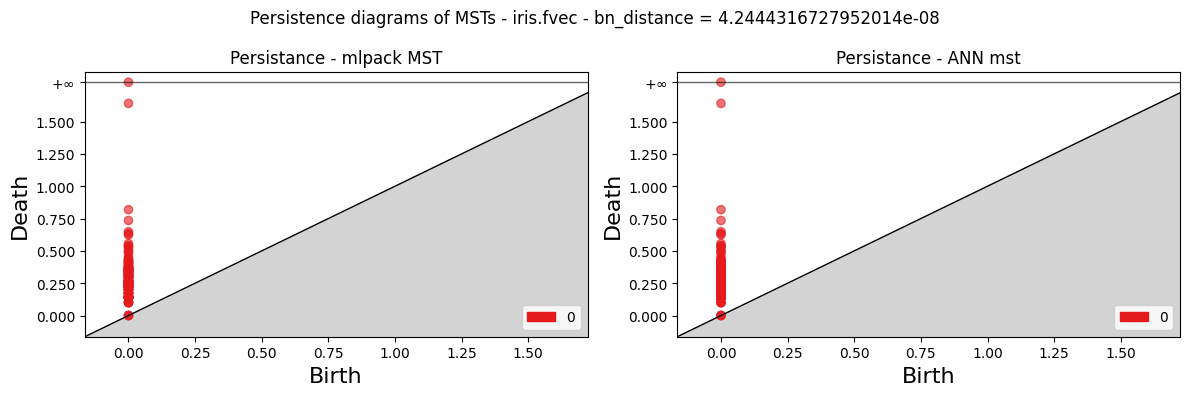

--


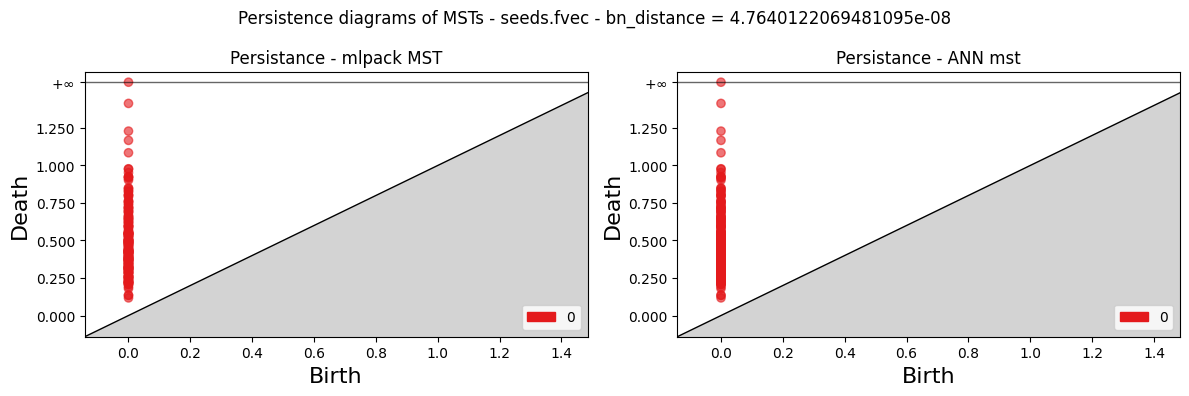

--


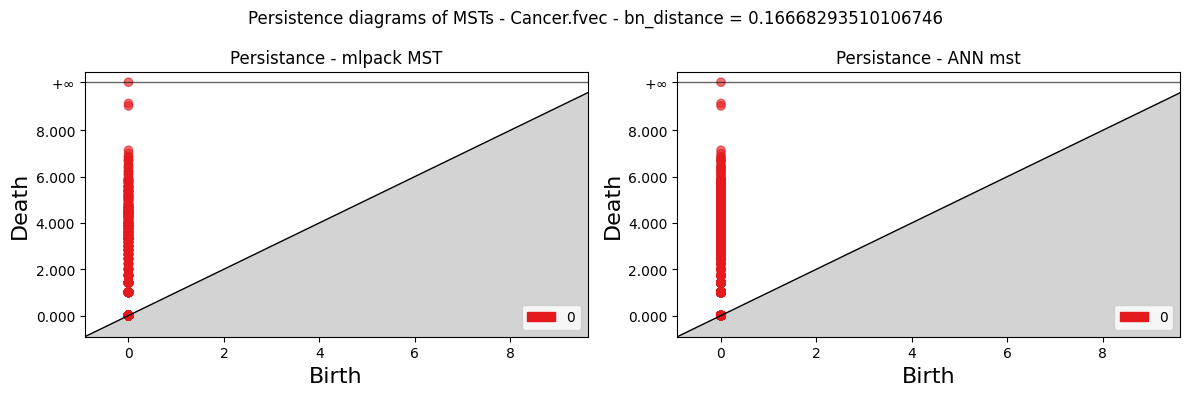

--


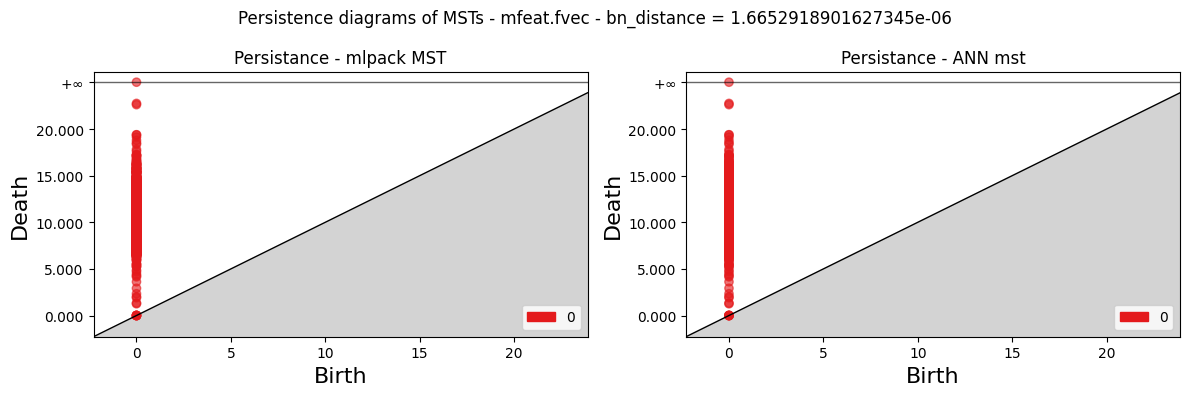

--


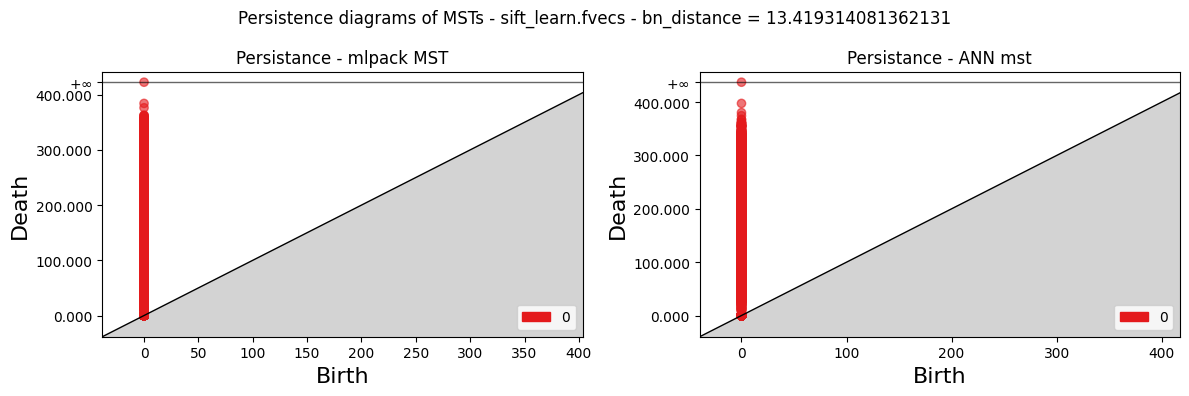

In [6]:
def run_all_ANN_tests():
    import pandas as pd
    from utils import MST_test_topology
    import os
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                    (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                    (os.path.join(name_of_dir, x)).st_size)

    results = []
    datasets =[]

    for dataset in list_of_files:
        if(dataset in ["mnist.fvec"]):
            continue
        datasets.append(dataset)
        
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        index_path = "data/" + f'index_{name}_R64_L100_A1.2'
        result = MST_test_topology(data_path, index_path,dataset)
        
        results.append(result)

        col_names = ["mlpack_building_time","ANN_building time","Bottleneck distance","number of equal_edges","percentual of equal edges","weight of equal edges","percentual weight of equal edges", "percentual total error"]

    df = pd.DataFrame(results, columns = col_names)
    
    
    df.index = datasets
    return df
    

df =run_all_ANN_tests()







In [7]:
import pandas as pd
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(df)

                  mlpack_building_time  ANN_building time  \
iris.fvec                        0.000              0.026   
seeds.fvec                       0.003              0.030   
Cancer.fvec                      0.027              0.129   
mfeat.fvec                       1.516              0.771   
sift_learn.fvecs              6826.458             62.179   

                  Bottleneck distance  number of equal_edges  \
iris.fvec                       0.000                    142   
seeds.fvec                      0.000                    209   
Cancer.fvec                     0.167                    407   
mfeat.fvec                      0.000                   1995   
sift_learn.fvecs               13.419                  97336   

                  percentual of equal edges  weight of equal edges  \
iris.fvec                             0.953                 42.267   
seeds.fvec                            1.000                101.510   
Cancer.fvec                           

In [8]:
df

,mlpack_building_time,ANN_building time,Bottleneck distance,number of equal_edges,percentual of equal edges,weight of equal edges,percentual weight of equal edges,percentual total error
iris.fvec,0.000000,0.026030,4.244432e-08,142,0.953020,4.226674e+01,0.974500,1.230495e-09
seeds.fvec,0.002991,0.029512,4.764012e-08,209,1.000000,1.015096e+02,1.000000,2.009997e-09
Cancer.fvec,0.026555,0.128536,1.666829e-01,407,0.583095,1.227731e+03,0.878250,1.000152e-03
mfeat.fvec,1.515977,0.771244,1.665292e-06,1995,0.997999,2.154611e+04,0.997847,9.996374e-10
sift_learn.fvecs,6826.458144,62.178939,1.341931e+01,97336,0.973370,2.030978e+07,0.968821,6.553204e-04


In [9]:
df.to_csv('mst_comparison.csv')

In [8]:
from TopoMap import TopoMap
from dataset_utils import fvecs_read
import numpy as np
import pandas as pd

def run_all_mlpack_check():
    import os
    name_of_dir = "fvec_datasets"

    list_of_files = filter( lambda x: os.path.isfile 
                    (os.path.join(name_of_dir, x)), 
                        os.listdir(name_of_dir) ) 
    list_of_files = sorted( list_of_files, 
                        key =  lambda x: os.stat 
                    (os.path.join(name_of_dir, x)).st_size)

    results = []
    datasets =[]

    for dataset in list_of_files:
        if(dataset in ["mnist.fvec",'sift_learn.fvecs']):
            continue
        datasets.append(dataset)
        
        data_path = os.path.join(name_of_dir,dataset)
        name = dataset.split(".")[0]
        points = fvecs_read(data_path)
        topo = TopoMap(points,approach ='mlpack')
        mst = topo.get_mst()
        sorted_edges = topo.get_sorted_edges()
        errors = 0
        for i in range(len(mst)):
            e1 = mst[i,0]
            e2 = mst[i,1]
            distance = np.linalg.norm(points[e1,:]- points[e2,:])
            if(abs(distance - mst[i,2])> 1e-5):
                print("error")
                print(name,e1,e2,distance,mst[i,2])
                errors +=1

        errors_sorted = 0
        
        for i in range(len(sorted_edges)):
            e1 = sorted_edges[i,0]
            e2 = sorted_edges[i,1]
            distance = np.linalg.norm(points[e1,:]- points[e2,:])
            if(abs(distance - sorted_edges[i,2])> 1e-5):
                print("error")
                print(name,e1,e2,distance,sorted_edges[i,2])
                errors_sorted +=1

        
        
        results.append([errors,errors_sorted])

        col_names = ["# errors", "errors_sorted"]

    df = pd.DataFrame(results, columns = col_names)
    
    
    df.index = datasets
    return df
    

df =run_all_mlpack_check()







In [19]:
import csv
from pathlib import Path


outpath = Path("test_csv.csv")
outpath.parent.mkdir(exist_ok=True)  # ensure the "out" directory exists

with outpath.open("a", newline="", encoding="utf-8-sig") as outfile:
    writer = csv.DictWriter(outfile, ["Last name","First name","Middle name","Role","School","Grade"])
    new_row = {"First name": "Jane", "Last name": "Smith","Role":"asd"}
    writer.writerow(new_row)